# Read data

In [1]:
import os
import sys
from os.path import dirname

In [2]:
## When using kaggle env
# path_root = "/kaggle/"

## Local env
path_root = "../data/"

In [3]:
## Add spark
# !tar xf /kaggle/input/pyspark-3-5-0/spark-3.5.0-bin-hadoop3.tgz
# if not os.path.isdir("spark"):
#     os.rename("spark-3.5.0-bin-hadoop3", "spark")
# sys.path.append(dirname(os.path.join(path_root, "working/spark/python/")))

In [4]:
from pyspark.sql.functions import col, count, max, mean, median, min, std, when

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# !pip install pyspark

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import col, count, max, mean, median, min, std, when
from pyspark.sql.types import (
    BooleanType,
    ByteType,
    DateType,
    DoubleType,
    IntegerType,
    LongType,
    StringType,
    StructField,
    StructType,
)
from scipy.stats import ks_2samp

pd.set_option("display.max_columns", 50)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

train_files = []
files = []
import os

for dirname, _, filenames in os.walk(os.path.join(path_root, "input")):
    for filename in filenames:
        f = os.path.join(dirname, filename)
        files.append(f)
#         print(os.path.join(dirname, filename))
train_files = [x for x in files if "/parquet_files/train" in x]
train_files.sort()

files.sort()

df_feature_definitions = pd.read_csv(
    os.path.join(
        path_root,
        "input/home-credit-credit-risk-model-stability/feature_definitions.csv",
    )
)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# spark = SparkSession.builder.appName('First Session').getOrCreate()
spark = (
    SparkSession.builder.master("local[*]")
    .config("spark.driver.maxResultSize", "10g")
    .config("spark.driver.memory", "10g")
    .config("spark.executor.memory", "10g")
    .getOrCreate()
)

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

print("Spark Version: {}".format(spark.version))

24/02/15 19:11:52 WARN Utils: Your hostname, DESKTOP-8S53VC0 resolves to a loopback address: 127.0.1.1; using 172.29.16.163 instead (on interface eth0)
24/02/15 19:11:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/15 19:11:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.0


In [6]:
schemas = {}
schemas["applprev_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("actualdpd_943P", DoubleType(), nullable=True),
        StructField("annuity_853A", DoubleType(), nullable=True),
        StructField("approvaldate_319D", DateType(), nullable=True),
        StructField("byoccupationinc_3656910L", DoubleType(), nullable=True),
        StructField("cancelreason_3545846M", StringType(), nullable=True),
        StructField("childnum_21L", DoubleType(), nullable=True),
        StructField("creationdate_885D", DateType(), nullable=True),
        StructField("credacc_actualbalance_314A", DoubleType(), nullable=True),
        StructField("credacc_credlmt_575A", DoubleType(), nullable=True),
        StructField("credacc_maxhisbal_375A", DoubleType(), nullable=True),
        StructField("credacc_minhisbal_90A", DoubleType(), nullable=True),
        StructField("credacc_status_367L", StringType(), nullable=True),
        StructField("credacc_transactions_402L", DoubleType(), nullable=True),
        StructField("credamount_590A", DoubleType(), nullable=True),
        StructField("credtype_587L", StringType(), nullable=True),
        StructField("currdebt_94A", DoubleType(), nullable=True),
        StructField("dateactivated_425D", StringType(), nullable=True),
        StructField("district_544M", StringType(), nullable=True),
        StructField("downpmt_134A", DoubleType(), nullable=True),
        StructField("dtlastpmt_581D", StringType(), nullable=True),
        StructField("dtlastpmtallstes_3545839D", StringType(), nullable=True),
        StructField("education_1138M", StringType(), nullable=True),
        StructField("employedfrom_700D", StringType(), nullable=True),
        StructField("familystate_726L", StringType(), nullable=True),
        StructField("firstnonzeroinstldate_307D", DateType(), nullable=True),
        StructField("inittransactioncode_279L", StringType(), nullable=True),
        StructField("isbidproduct_390L", BooleanType(), nullable=True),
        StructField("isdebitcard_527L", BooleanType(), nullable=True),
        StructField("mainoccupationinc_437A", DoubleType(), nullable=True),
        StructField("maxdpdtolerance_577P", DoubleType(), nullable=True),
        StructField("num_group1", ByteType(), nullable=True),
        StructField("outstandingdebt_522A", DoubleType(), nullable=True),
        StructField("pmtnum_8L", DoubleType(), nullable=True),
        StructField("postype_4733339M", StringType(), nullable=True),
        StructField("profession_152M", StringType(), nullable=True),
        StructField("rejectreason_755M", StringType(), nullable=True),
        StructField("rejectreasonclient_4145042M", StringType(), nullable=True),
        StructField("revolvingaccount_394A", DoubleType(), nullable=True),
        StructField("status_219L", StringType(), nullable=True),
        StructField("tenor_203L", DoubleType(), nullable=True),
    ]
)

schemas["static_0"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("actualdpdtolerance_344P", DoubleType(), nullable=True),
        StructField("amtinstpaidbefduel24m_4187115A", DoubleType(), nullable=True),
        StructField("annuity_780A", DoubleType(), nullable=True),
        StructField("annuitynextmonth_57A", DoubleType(), nullable=True),
        StructField("applicationcnt_361L", DoubleType(), nullable=True),
        StructField("applications30d_658L", DoubleType(), nullable=True),
        StructField("applicationscnt_1086L", DoubleType(), nullable=True),
        StructField("applicationscnt_464L", DoubleType(), nullable=True),
        StructField("applicationscnt_629L", DoubleType(), nullable=True),
        StructField("applicationscnt_867L", DoubleType(), nullable=True),
        StructField("avgdbddpdlast24m_3658932P", DoubleType(), nullable=True),
        StructField("avgdbddpdlast3m_4187120P", DoubleType(), nullable=True),
        StructField("avgdbdtollast24m_4525197P", DoubleType(), nullable=True),
        StructField("avgdpdtolclosure24_3658938P", DoubleType(), nullable=True),
        StructField("avginstallast24m_3658937A", DoubleType(), nullable=True),
        StructField("avglnamtstart24m_4525187A", DoubleType(), nullable=True),
        StructField("avgmaxdpdlast9m_3716943P", DoubleType(), nullable=True),
        StructField("avgoutstandbalancel6m_4187114A", DoubleType(), nullable=True),
        StructField("avgpmtlast12m_4525200A", DoubleType(), nullable=True),
        StructField("bankacctype_710L", StringType(), nullable=True),
        StructField("cardtype_51L", StringType(), nullable=True),
        StructField("clientscnt12m_3712952L", DoubleType(), nullable=True),
        StructField("clientscnt3m_3712950L", DoubleType(), nullable=True),
        StructField("clientscnt6m_3712949L", DoubleType(), nullable=True),
        StructField("clientscnt_100L", DoubleType(), nullable=True),
        StructField("clientscnt_1022L", DoubleType(), nullable=True),
        StructField("clientscnt_1071L", DoubleType(), nullable=True),
        StructField("clientscnt_1130L", DoubleType(), nullable=True),
        StructField("clientscnt_136L", DoubleType(), nullable=True),
        StructField("clientscnt_157L", DoubleType(), nullable=True),
        StructField("clientscnt_257L", DoubleType(), nullable=True),
        StructField("clientscnt_304L", DoubleType(), nullable=True),
        StructField("clientscnt_360L", DoubleType(), nullable=True),
        StructField("clientscnt_493L", DoubleType(), nullable=True),
        StructField("clientscnt_533L", DoubleType(), nullable=True),
        StructField("clientscnt_887L", DoubleType(), nullable=True),
        StructField("clientscnt_946L", DoubleType(), nullable=True),
        StructField("cntincpaycont9m_3716944L", DoubleType(), nullable=True),
        StructField("cntpmts24_3658933L", DoubleType(), nullable=True),
        StructField("commnoinclast6m_3546845L", DoubleType(), nullable=True),
        StructField("credamount_770A", DoubleType(), nullable=True),
        StructField("credtype_322L", StringType(), nullable=True),
        StructField("currdebt_22A", DoubleType(), nullable=True),
        StructField("currdebtcredtyperange_828A", DoubleType(), nullable=True),
        StructField("datefirstoffer_1144D", DateType(), nullable=True),
        StructField("datelastinstal40dpd_247D", DateType(), nullable=True),
        StructField("datelastunpaid_3546854D", DateType(), nullable=True),
        StructField("daysoverduetolerancedd_3976961L", DoubleType(), nullable=True),
        StructField("deferredmnthsnum_166L", DoubleType(), nullable=True),
        StructField("disbursedcredamount_1113A", DoubleType(), nullable=True),
        StructField("disbursementtype_67L", StringType(), nullable=True),
        StructField("downpmt_116A", DoubleType(), nullable=True),
        StructField("dtlastpmtallstes_4499206D", DateType(), nullable=True),
        StructField("eir_270L", DoubleType(), nullable=True),
        StructField("equalitydataagreement_891L", BooleanType(), nullable=True),
        StructField("equalityempfrom_62L", BooleanType(), nullable=True),
        StructField("firstclxcampaign_1125D", DateType(), nullable=True),
        StructField("firstdatedue_489D", DateType(), nullable=True),
        StructField("homephncnt_628L", DoubleType(), nullable=True),
        StructField("inittransactionamount_650A", DoubleType(), nullable=True),
        StructField("inittransactioncode_186L", StringType(), nullable=True),
        StructField("interestrate_311L", DoubleType(), nullable=True),
        StructField("interestrategrace_34L", DoubleType(), nullable=True),
        StructField("isbidproduct_1095L", BooleanType(), nullable=True),
        StructField("isbidproductrequest_292L", BooleanType(), nullable=True),
        StructField("isdebitcard_729L", BooleanType(), nullable=True),
        StructField("lastactivateddate_801D", DateType(), nullable=True),
        StructField("lastapplicationdate_877D", DateType(), nullable=True),
        StructField("lastapprcommoditycat_1041M", StringType(), nullable=True),
        StructField("lastapprcommoditytypec_5251766M", StringType(), nullable=True),
        StructField("lastapprcredamount_781A", DoubleType(), nullable=True),
        StructField("lastapprdate_640D", DateType(), nullable=True),
        StructField("lastcancelreason_561M", StringType(), nullable=True),
        StructField("lastdelinqdate_224D", DateType(), nullable=True),
        StructField("lastdependentsnum_448L", DoubleType(), nullable=True),
        StructField("lastotherinc_902A", DoubleType(), nullable=True),
        StructField("lastotherlnsexpense_631A", DoubleType(), nullable=True),
        StructField("lastrejectcommoditycat_161M", StringType(), nullable=True),
        StructField("lastrejectcommodtypec_5251769M", StringType(), nullable=True),
        StructField("lastrejectcredamount_222A", DoubleType(), nullable=True),
        StructField("lastrejectdate_50D", DateType(), nullable=True),
        StructField("lastrejectreason_759M", StringType(), nullable=True),
        StructField("lastrejectreasonclient_4145040M", StringType(), nullable=True),
        StructField("lastrepayingdate_696D", DateType(), nullable=True),
        StructField("lastst_736L", StringType(), nullable=True),
        StructField("maininc_215A", DoubleType(), nullable=True),
        StructField("mastercontrelectronic_519L", DoubleType(), nullable=True),
        StructField("mastercontrexist_109L", DoubleType(), nullable=True),
        StructField("maxannuity_159A", DoubleType(), nullable=True),
        StructField("maxannuity_4075009A", DoubleType(), nullable=True),
        StructField("maxdbddpdlast1m_3658939P", DoubleType(), nullable=True),
        StructField("maxdbddpdtollast12m_3658940P", DoubleType(), nullable=True),
        StructField("maxdbddpdtollast6m_4187119P", DoubleType(), nullable=True),
        StructField("maxdebt4_972A", DoubleType(), nullable=True),
        StructField("maxdpdfrom6mto36m_3546853P", DoubleType(), nullable=True),
        StructField("maxdpdinstldate_3546855D", DateType(), nullable=True),
        StructField("maxdpdinstlnum_3546846P", DoubleType(), nullable=True),
        StructField("maxdpdlast12m_727P", DoubleType(), nullable=True),
        StructField("maxdpdlast24m_143P", DoubleType(), nullable=True),
        StructField("maxdpdlast3m_392P", DoubleType(), nullable=True),
        StructField("maxdpdlast6m_474P", DoubleType(), nullable=True),
        StructField("maxdpdlast9m_1059P", DoubleType(), nullable=True),
        StructField("maxdpdtolerance_374P", DoubleType(), nullable=True),
        StructField("maxinstallast24m_3658928A", DoubleType(), nullable=True),
        StructField("maxlnamtstart6m_4525199A", DoubleType(), nullable=True),
        StructField("maxoutstandbalancel12m_4187113A", DoubleType(), nullable=True),
        StructField("maxpmtlast3m_4525190A", DoubleType(), nullable=True),
        StructField("mindbddpdlast24m_3658935P", DoubleType(), nullable=True),
        StructField("mindbdtollast24m_4525191P", DoubleType(), nullable=True),
        StructField("mobilephncnt_593L", DoubleType(), nullable=True),
        StructField("monthsannuity_845L", DoubleType(), nullable=True),
        StructField("numactivecreds_622L", DoubleType(), nullable=True),
        StructField("numactivecredschannel_414L", DoubleType(), nullable=True),
        StructField("numactiverelcontr_750L", DoubleType(), nullable=True),
        StructField("numcontrs3months_479L", DoubleType(), nullable=True),
        StructField("numincomingpmts_3546848L", DoubleType(), nullable=True),
        StructField("numinstlallpaidearly3d_817L", DoubleType(), nullable=True),
        StructField("numinstls_657L", DoubleType(), nullable=True),
        StructField("numinstlsallpaid_934L", DoubleType(), nullable=True),
        StructField("numinstlswithdpd10_728L", DoubleType(), nullable=True),
        StructField("numinstlswithdpd5_4187116L", DoubleType(), nullable=True),
        StructField("numinstlswithoutdpd_562L", DoubleType(), nullable=True),
        StructField("numinstmatpaidtearly2d_4499204L", DoubleType(), nullable=True),
        StructField("numinstpaid_4499208L", DoubleType(), nullable=True),
        StructField("numinstpaidearly3d_3546850L", DoubleType(), nullable=True),
        StructField("numinstpaidearly3dest_4493216L", DoubleType(), nullable=True),
        StructField("numinstpaidearly5d_1087L", DoubleType(), nullable=True),
        StructField("numinstpaidearly5dest_4493211L", DoubleType(), nullable=True),
        StructField("numinstpaidearly5dobd_4499205L", DoubleType(), nullable=True),
        StructField("numinstpaidearly_338L", DoubleType(), nullable=True),
        StructField("numinstpaidearlyest_4493214L", DoubleType(), nullable=True),
        StructField("numinstpaidlastcontr_4325080L", DoubleType(), nullable=True),
        StructField("numinstpaidlate1d_3546852L", DoubleType(), nullable=True),
        StructField("numinstregularpaid_973L", DoubleType(), nullable=True),
        StructField("numinstregularpaidest_4493210L", DoubleType(), nullable=True),
        StructField("numinsttopaygr_769L", DoubleType(), nullable=True),
        StructField("numinsttopaygrest_4493213L", DoubleType(), nullable=True),
        StructField("numinstunpaidmax_3546851L", DoubleType(), nullable=True),
        StructField("numinstunpaidmaxest_4493212L", DoubleType(), nullable=True),
        StructField("numnotactivated_1143L", DoubleType(), nullable=True),
        StructField("numpmtchanneldd_318L", DoubleType(), nullable=True),
        StructField("numrejects9m_859L", DoubleType(), nullable=True),
        StructField("opencred_647L", BooleanType(), nullable=True),
        StructField("paytype1st_925L", StringType(), nullable=True),
        StructField("paytype_783L", StringType(), nullable=True),
        StructField("payvacationpostpone_4187118D", DateType(), nullable=True),
        StructField("pctinstlsallpaidearl3d_427L", DoubleType(), nullable=True),
        StructField("pctinstlsallpaidlat10d_839L", DoubleType(), nullable=True),
        StructField("pctinstlsallpaidlate1d_3546856L", DoubleType(), nullable=True),
        StructField("pctinstlsallpaidlate4d_3546849L", DoubleType(), nullable=True),
        StructField("pctinstlsallpaidlate6d_3546844L", DoubleType(), nullable=True),
        StructField("pmtnum_254L", DoubleType(), nullable=True),
        StructField("posfpd10lastmonth_333P", DoubleType(), nullable=True),
        StructField("posfpd30lastmonth_3976960P", DoubleType(), nullable=True),
        StructField("posfstqpd30lastmonth_3976962P", DoubleType(), nullable=True),
        StructField("previouscontdistrict_112M", StringType(), nullable=True),
        StructField("price_1097A", DoubleType(), nullable=True),
        StructField("sellerplacecnt_915L", DoubleType(), nullable=True),
        StructField("sellerplacescnt_216L", DoubleType(), nullable=True),
        StructField("sumoutstandtotal_3546847A", DoubleType(), nullable=True),
        StructField("sumoutstandtotalest_4493215A", DoubleType(), nullable=True),
        StructField("totaldebt_9A", DoubleType(), nullable=True),
        StructField("totalsettled_863A", DoubleType(), nullable=True),
        StructField("totinstallast1m_4525188A", DoubleType(), nullable=True),
        StructField("twobodfilling_608L", StringType(), nullable=True),
        StructField("typesuite_864L", StringType(), nullable=True),
        StructField("validfrom_1069D", DateType(), nullable=True),
    ]
)

schemas["credit_bureau_a_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("annualeffectiverate_199L", DoubleType(), nullable=True),
        StructField("annualeffectiverate_63L", DoubleType(), nullable=True),
        StructField("classificationofcontr_13M", StringType(), nullable=True),
        StructField("classificationofcontr_400M", StringType(), nullable=True),
        StructField("contractst_545M", StringType(), nullable=True),
        StructField("contractst_964M", StringType(), nullable=True),
        StructField("contractsum_5085717L", DoubleType(), nullable=True),
        StructField("credlmt_230A", DoubleType(), nullable=True),
        StructField("credlmt_935A", DoubleType(), nullable=True),
        StructField("dateofcredend_289D", DateType(), nullable=True),
        StructField("dateofcredend_353D", DateType(), nullable=True),
        StructField("dateofcredstart_181D", DateType(), nullable=True),
        StructField("dateofcredstart_739D", DateType(), nullable=True),
        StructField("dateofrealrepmt_138D", DateType(), nullable=True),
        StructField("debtoutstand_525A", DoubleType(), nullable=True),
        StructField("debtoverdue_47A", DoubleType(), nullable=True),
        StructField("description_351M", StringType(), nullable=True),
        StructField("dpdmax_139P", DoubleType(), nullable=True),
        StructField("dpdmax_757P", DoubleType(), nullable=True),
        StructField("dpdmaxdatemonth_442T", DoubleType(), nullable=True),
        StructField("dpdmaxdatemonth_89T", DoubleType(), nullable=True),
        StructField("dpdmaxdateyear_596T", DoubleType(), nullable=True),
        StructField("dpdmaxdateyear_896T", DoubleType(), nullable=True),
        StructField("financialinstitution_382M", StringType(), nullable=True),
        StructField("financialinstitution_591M", StringType(), nullable=True),
        StructField("instlamount_768A", DoubleType(), nullable=True),
        StructField("instlamount_852A", DoubleType(), nullable=True),
        StructField("interestrate_508L", DoubleType(), nullable=True),
        StructField("lastupdate_1112D", DateType(), nullable=True),
        StructField("lastupdate_388D", DateType(), nullable=True),
        StructField("monthlyinstlamount_332A", DoubleType(), nullable=True),
        StructField("monthlyinstlamount_674A", DoubleType(), nullable=True),
        StructField("nominalrate_281L", DoubleType(), nullable=True),
        StructField("nominalrate_498L", DoubleType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("numberofcontrsvalue_258L", DoubleType(), nullable=True),
        StructField("numberofcontrsvalue_358L", DoubleType(), nullable=True),
        StructField("numberofinstls_229L", DoubleType(), nullable=True),
        StructField("numberofinstls_320L", DoubleType(), nullable=True),
        StructField("numberofoutstandinstls_520L", DoubleType(), nullable=True),
        StructField("numberofoutstandinstls_59L", DoubleType(), nullable=True),
        StructField("numberofoverdueinstlmax_1039L", DoubleType(), nullable=True),
        StructField("numberofoverdueinstlmax_1151L", DoubleType(), nullable=True),
        StructField("numberofoverdueinstlmaxdat_148D", DateType(), nullable=True),
        StructField("numberofoverdueinstlmaxdat_641D", DateType(), nullable=True),
        StructField("numberofoverdueinstls_725L", DoubleType(), nullable=True),
        StructField("numberofoverdueinstls_834L", DoubleType(), nullable=True),
        StructField("outstandingamount_354A", DoubleType(), nullable=True),
        StructField("outstandingamount_362A", DoubleType(), nullable=True),
        StructField("overdueamount_31A", DoubleType(), nullable=True),
        StructField("overdueamount_659A", DoubleType(), nullable=True),
        StructField("overdueamountmax2_14A", DoubleType(), nullable=True),
        StructField("overdueamountmax2_398A", DoubleType(), nullable=True),
        StructField("overdueamountmax2date_1002D", DateType(), nullable=True),
        StructField("overdueamountmax2date_1142D", DateType(), nullable=True),
        StructField("overdueamountmax_155A", DoubleType(), nullable=True),
        StructField("overdueamountmax_35A", DoubleType(), nullable=True),
        StructField("overdueamountmaxdatemonth_284T", DoubleType(), nullable=True),
        StructField("overdueamountmaxdatemonth_365T", DoubleType(), nullable=True),
        StructField("overdueamountmaxdateyear_2T", DoubleType(), nullable=True),
        StructField("overdueamountmaxdateyear_994T", DoubleType(), nullable=True),
        StructField("periodicityofpmts_1102L", DoubleType(), nullable=True),
        StructField("periodicityofpmts_837L", DoubleType(), nullable=True),
        StructField("prolongationcount_1120L", DoubleType(), nullable=True),
        StructField("prolongationcount_599L", DoubleType(), nullable=True),
        StructField("purposeofcred_426M", StringType(), nullable=True),
        StructField("purposeofcred_874M", StringType(), nullable=True),
        StructField("refreshdate_3813885D", DateType(), nullable=True),
        StructField("residualamount_488A", DoubleType(), nullable=True),
        StructField("residualamount_856A", DoubleType(), nullable=True),
        StructField("subjectrole_182M", StringType(), nullable=True),
        StructField("subjectrole_93M", StringType(), nullable=True),
        StructField("totalamount_6A", DoubleType(), nullable=True),
        StructField("totalamount_996A", DoubleType(), nullable=True),
        StructField("totaldebtoverduevalue_178A", DoubleType(), nullable=True),
        StructField("totaldebtoverduevalue_718A", DoubleType(), nullable=True),
        StructField("totaloutstanddebtvalue_39A", DoubleType(), nullable=True),
        StructField("totaloutstanddebtvalue_668A", DoubleType(), nullable=True),
    ]
)

schemas["credit_bureau_a_2"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("collater_typofvalofguarant_298M", StringType(), nullable=True),
        StructField("collater_typofvalofguarant_407M", StringType(), nullable=True),
        StructField("collater_valueofguarantee_1124L", DoubleType(), nullable=True),
        StructField("collater_valueofguarantee_876L", DoubleType(), nullable=True),
        StructField("collaterals_typeofguarante_359M", StringType(), nullable=True),
        StructField("collaterals_typeofguarante_669M", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("num_group2", LongType(), nullable=True),
        StructField("pmts_dpd_1073P", DoubleType(), nullable=True),
        StructField("pmts_dpd_303P", DoubleType(), nullable=True),
        StructField("pmts_month_158T", DoubleType(), nullable=True),
        StructField("pmts_month_706T", DoubleType(), nullable=True),
        StructField("pmts_overdue_1140A", DoubleType(), nullable=True),
        StructField("pmts_overdue_1152A", DoubleType(), nullable=True),
        StructField("pmts_year_1139T", DoubleType(), nullable=True),
        StructField("pmts_year_507T", DoubleType(), nullable=True),
        StructField("subjectroles_name_541M", StringType(), nullable=True),
        StructField("subjectroles_name_838M", StringType(), nullable=True),
    ]
)

schemas["applprev_2"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("cacccardblochreas_147M", StringType(), nullable=True),
        StructField("conts_type_509L", StringType(), nullable=True),
        StructField("credacc_cards_status_52L", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("num_group2", LongType(), nullable=True),
    ]
)

schemas["base"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("date_decision", StringType(), nullable=True),
        StructField("MONTH", LongType(), nullable=True),
        StructField("WEEK_NUM", LongType(), nullable=True),
        StructField("target", LongType(), nullable=True),
    ]
)

schemas["credit_bureau_b_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("amount_1115A", DoubleType(), nullable=True),
        StructField("classificationofcontr_1114M", StringType(), nullable=True),
        StructField("contractdate_551D", DateType(), nullable=True),
        StructField("contractmaturitydate_151D", DateType(), nullable=True),
        StructField("contractst_516M", StringType(), nullable=True),
        StructField("contracttype_653M", StringType(), nullable=True),
        StructField("credlmt_1052A", DoubleType(), nullable=True),
        StructField("credlmt_228A", DoubleType(), nullable=True),
        StructField("credlmt_3940954A", DoubleType(), nullable=True),
        StructField("credor_3940957M", StringType(), nullable=True),
        StructField("credquantity_1099L", DoubleType(), nullable=True),
        StructField("credquantity_984L", DoubleType(), nullable=True),
        StructField("debtpastduevalue_732A", DoubleType(), nullable=True),
        StructField("debtvalue_227A", DoubleType(), nullable=True),
        StructField("dpd_550P", DoubleType(), nullable=True),
        StructField("dpd_733P", DoubleType(), nullable=True),
        StructField("dpdmax_851P", DoubleType(), nullable=True),
        StructField("dpdmaxdatemonth_804T", DoubleType(), nullable=True),
        StructField("dpdmaxdateyear_742T", DoubleType(), nullable=True),
        StructField("installmentamount_644A", DoubleType(), nullable=True),
        StructField("installmentamount_833A", DoubleType(), nullable=True),
        StructField("instlamount_892A", DoubleType(), nullable=True),
        StructField("interesteffectiverate_369L", DoubleType(), nullable=True),
        StructField("interestrateyearly_538L", DoubleType(), nullable=True),
        StructField("lastupdate_260D", DateType(), nullable=True),
        StructField("maxdebtpduevalodued_3940955A", DoubleType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("numberofinstls_810L", DoubleType(), nullable=True),
        StructField("overdueamountmax_950A", DoubleType(), nullable=True),
        StructField("overdueamountmaxdatemonth_494T", DoubleType(), nullable=True),
        StructField("overdueamountmaxdateyear_432T", DoubleType(), nullable=True),
        StructField("periodicityofpmts_997L", StringType(), nullable=True),
        StructField("periodicityofpmts_997M", StringType(), nullable=True),
        StructField("pmtdaysoverdue_1135P", DoubleType(), nullable=True),
        StructField("pmtmethod_731M", StringType(), nullable=True),
        StructField("pmtnumpending_403L", DoubleType(), nullable=True),
        StructField("purposeofcred_722M", StringType(), nullable=True),
        StructField("residualamount_1093A", DoubleType(), nullable=True),
        StructField("residualamount_127A", DoubleType(), nullable=True),
        StructField("residualamount_3940956A", DoubleType(), nullable=True),
        StructField("subjectrole_326M", StringType(), nullable=True),
        StructField("subjectrole_43M", StringType(), nullable=True),
        StructField("totalamount_503A", DoubleType(), nullable=True),
        StructField("totalamount_881A", DoubleType(), nullable=True),
    ]
)


schemas["credit_bureau_b_2"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("num_group2", LongType(), nullable=True),
        StructField("pmts_date_1107D", DateType(), nullable=True),
        StructField("pmts_dpdvalue_108P", DoubleType(), nullable=True),
        StructField("pmts_pmtsoverdue_635A", DoubleType(), nullable=True),
    ]
)

schemas["debitcard_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("last180dayaveragebalance_704A", DoubleType(), nullable=True),
        StructField("last180dayturnover_1134A", DoubleType(), nullable=True),
        StructField("last30dayturnover_651A", DoubleType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("openingdate_857D", DateType(), nullable=True),
    ]
)

schemas["deposit_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("amount_416A", DoubleType(), nullable=True),
        StructField("contractenddate_991D", DateType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("openingdate_313D", DateType(), nullable=True),
    ]
)

schemas["other_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("amtdebitincoming_4809443A", DoubleType(), nullable=True),
        StructField("amtdebitoutgoing_4809440A", DoubleType(), nullable=True),
        StructField("amtdepositbalance_4809441A", DoubleType(), nullable=True),
        StructField("amtdepositincoming_4809444A", DoubleType(), nullable=True),
        StructField("amtdepositoutgoing_4809442A", DoubleType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
    ]
)

schemas["person_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("birth_259D", DateType(), nullable=True),
        StructField("birthdate_87D", DateType(), nullable=True),
        StructField("childnum_185L", DoubleType(), nullable=True),
        StructField("contaddr_district_15M", StringType(), nullable=True),
        StructField("contaddr_matchlist_1032L", BooleanType(), nullable=True),
        StructField("contaddr_smempladdr_334L", BooleanType(), nullable=True),
        StructField("contaddr_zipcode_807M", StringType(), nullable=True),
        StructField("education_927M", StringType(), nullable=True),
        StructField("empl_employedfrom_271D", DateType(), nullable=True),
        StructField("empl_employedtotal_800L", StringType(), nullable=True),
        StructField("empl_industry_691L", StringType(), nullable=True),
        StructField("empladdr_district_926M", StringType(), nullable=True),
        StructField("empladdr_zipcode_114M", StringType(), nullable=True),
        StructField("familystate_447L", StringType(), nullable=True),
        StructField("gender_992L", StringType(), nullable=True),
        StructField("housetype_905L", StringType(), nullable=True),
        StructField("housingtype_772L", StringType(), nullable=True),
        StructField("incometype_1044T", StringType(), nullable=True),
        StructField("isreference_387L", BooleanType(), nullable=True),
        StructField("language1_981M", StringType(), nullable=True),
        StructField("mainoccupationinc_384A", DoubleType(), nullable=True),
        StructField("maritalst_703L", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("personindex_1023L", DoubleType(), nullable=True),
        StructField("persontype_1072L", DoubleType(), nullable=True),
        StructField("persontype_792L", DoubleType(), nullable=True),
        StructField("registaddr_district_1083M", StringType(), nullable=True),
        StructField("registaddr_zipcode_184M", StringType(), nullable=True),
        StructField("relationshiptoclient_415T", StringType(), nullable=True),
        StructField("relationshiptoclient_642T", StringType(), nullable=True),
        StructField("remitter_829L", BooleanType(), nullable=True),
        StructField("role_1084L", StringType(), nullable=True),
        StructField("role_993L", StringType(), nullable=True),
        StructField("safeguarantyflag_411L", BooleanType(), nullable=True),
        StructField("sex_738L", StringType(), nullable=True),
        StructField("type_25L", StringType(), nullable=True),
    ]
)

schemas["person_2"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("addres_district_368M", StringType(), nullable=True),
        StructField("addres_role_871L", StringType(), nullable=True),
        StructField("addres_zip_823M", StringType(), nullable=True),
        StructField("conts_role_79M", StringType(), nullable=True),
        StructField("empls_economicalst_849M", StringType(), nullable=True),
        StructField("empls_employedfrom_796D", DateType(), nullable=True),
        StructField("empls_employer_name_740M", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("num_group2", LongType(), nullable=True),
        StructField("relatedpersons_role_762T", StringType(), nullable=True),
    ]
)

schemas["static_cb_0"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("assignmentdate_238D", DateType(), nullable=True),
        StructField("assignmentdate_4527235D", DateType(), nullable=True),
        StructField("assignmentdate_4955616D", DateType(), nullable=True),
        StructField("birthdate_574D", DateType(), nullable=True),
        StructField("contractssum_5085716L", DoubleType(), nullable=True),
        StructField("dateofbirth_337D", DateType(), nullable=True),
        StructField("dateofbirth_342D", DateType(), nullable=True),
        StructField("days120_123L", DoubleType(), nullable=True),
        StructField("days180_256L", DoubleType(), nullable=True),
        StructField("days30_165L", DoubleType(), nullable=True),
        StructField("days360_512L", DoubleType(), nullable=True),
        StructField("days90_310L", DoubleType(), nullable=True),
        StructField("description_5085714M", StringType(), nullable=True),
        StructField("education_1103M", StringType(), nullable=True),
        StructField("education_88M", StringType(), nullable=True),
        StructField("firstquarter_103L", DoubleType(), nullable=True),
        StructField("for3years_128L", DoubleType(), nullable=True),
        StructField("for3years_504L", DoubleType(), nullable=True),
        StructField("for3years_584L", DoubleType(), nullable=True),
        StructField("formonth_118L", DoubleType(), nullable=True),
        StructField("formonth_206L", DoubleType(), nullable=True),
        StructField("formonth_535L", DoubleType(), nullable=True),
        StructField("forquarter_1017L", DoubleType(), nullable=True),
        StructField("forquarter_462L", DoubleType(), nullable=True),
        StructField("forquarter_634L", DoubleType(), nullable=True),
        StructField("fortoday_1092L", DoubleType(), nullable=True),
        StructField("forweek_1077L", DoubleType(), nullable=True),
        StructField("forweek_528L", DoubleType(), nullable=True),
        StructField("forweek_601L", DoubleType(), nullable=True),
        StructField("foryear_618L", DoubleType(), nullable=True),
        StructField("foryear_818L", DoubleType(), nullable=True),
        StructField("foryear_850L", DoubleType(), nullable=True),
        StructField("fourthquarter_440L", DoubleType(), nullable=True),
        StructField("maritalst_385M", StringType(), nullable=True),
        StructField("maritalst_893M", StringType(), nullable=True),
        StructField("numberofqueries_373L", DoubleType(), nullable=True),
        StructField("pmtaverage_3A", DoubleType(), nullable=True),
        StructField("pmtaverage_4527227A", DoubleType(), nullable=True),
        StructField("pmtaverage_4955615A", DoubleType(), nullable=True),
        StructField("pmtcount_4527229L", DoubleType(), nullable=True),
        StructField("pmtcount_4955617L", DoubleType(), nullable=True),
        StructField("pmtcount_693L", DoubleType(), nullable=True),
        StructField("pmtscount_423L", DoubleType(), nullable=True),
        StructField("pmtssum_45A", DoubleType(), nullable=True),
        StructField("requesttype_4525192L", StringType(), nullable=True),
        StructField("responsedate_1012D", DateType(), nullable=True),
        StructField("responsedate_4527233D", DateType(), nullable=True),
        StructField("responsedate_4917613D", DateType(), nullable=True),
        StructField("riskassesment_302T", StringType(), nullable=True),
        StructField("riskassesment_940T", DoubleType(), nullable=True),
        StructField("secondquarter_766L", DoubleType(), nullable=True),
        StructField("thirdquarter_1082L", DoubleType(), nullable=True),
    ]
)

schemas["tax_registry_a_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("amount_4527230A", DoubleType(), nullable=True),
        StructField("name_4527232M", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("recorddate_4527225D", DateType(), nullable=True),
    ]
)

schemas["tax_registry_b_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("amount_4917619A", DoubleType(), nullable=True),
        StructField("deductiondate_4917603D", DateType(), nullable=True),
        StructField("name_4917606M", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
    ]
)

schemas["tax_registry_c_1"] = StructType(
    [
        StructField("case_id", LongType(), nullable=True),
        StructField("employername_160M", StringType(), nullable=True),
        StructField("num_group1", LongType(), nullable=True),
        StructField("pmtamount_36A", DoubleType(), nullable=True),
        StructField("processingdate_168D", DateType(), nullable=True),
    ]
)

In [7]:
def get_correct_schema_and_f_name(path):
    # Split core file name from path
    f_name = path.split("/")[-1].split(".")[0].split("_", 1)[1]

    # Get matchin schema key
    matching_keys = [x for x in list(schemas.keys()) if x in f_name]
    assert len(matching_keys) == 1, "Should be exactly 1 match. Returned: " + str(
        matching_keys
    )
    k = matching_keys[0]

    return (f_name, schemas[k], k)

In [8]:
def read_data():
    # Read files into Spark DataFrame
    d_df = {}
    for path in train_files:
        (f_name, schema, k) = get_correct_schema_and_f_name(path)

        #         print(f_name, k)

        d_df[f_name] = spark.read.schema(schema).parquet(
            path, header=True, inferSchema=False
        )

    ## Concat similar DataFrames into one
    # applprev_1
    d_df["applprev_1"] = d_df["applprev_1_0"].union(d_df["applprev_1_1"])
    del d_df["applprev_1_0"], d_df["applprev_1_1"]

    # static_0
    d_df["static_0"] = d_df["static_0_0"].union(d_df["static_0_1"])
    del d_df["static_0_0"], d_df["static_0_1"]

    # credit_bureau_a_1
    d_df["credit_bureau_a_1"] = (
        d_df["credit_bureau_a_1_0"]
        .union(d_df["credit_bureau_a_1_1"])
        .union(d_df["credit_bureau_a_1_2"])
        .union(d_df["credit_bureau_a_1_3"])
    )
    del (
        d_df["credit_bureau_a_1_0"],
        d_df["credit_bureau_a_1_1"],
        d_df["credit_bureau_a_1_2"],
        d_df["credit_bureau_a_1_3"],
    )

    # credit_bureau_a_2
    d_df["credit_bureau_a_2"] = (
        d_df["credit_bureau_a_2_0"]
        .union(d_df["credit_bureau_a_2_1"])
        .union(d_df["credit_bureau_a_2_2"])
        .union(d_df["credit_bureau_a_2_3"])
        .union(d_df["credit_bureau_a_2_4"])
        .union(d_df["credit_bureau_a_2_5"])
        .union(d_df["credit_bureau_a_2_6"])
        .union(d_df["credit_bureau_a_2_7"])
        .union(d_df["credit_bureau_a_2_8"])
        .union(d_df["credit_bureau_a_2_9"])
        .union(d_df["credit_bureau_a_2_10"])
    )
    del (
        d_df["credit_bureau_a_2_0"],
        d_df["credit_bureau_a_2_1"],
        d_df["credit_bureau_a_2_2"],
        d_df["credit_bureau_a_2_3"],
        d_df["credit_bureau_a_2_4"],
        d_df["credit_bureau_a_2_5"],
        d_df["credit_bureau_a_2_6"],
        d_df["credit_bureau_a_2_7"],
        d_df["credit_bureau_a_2_8"],
        d_df["credit_bureau_a_2_9"],
        d_df["credit_bureau_a_2_10"],
    )

    return d_df

In [9]:
d_df = read_data()

## Compare distributions

In [10]:
from scipy.stats import ks_2samp

In [11]:
def prepare_dfs(df_new, df_base):
    df_joined = df_new.join(df_base[["case_id", "target"]], "case_id", "left")

    # Columns which are not used for features
    cols = df_joined.columns
    cols.remove("case_id")
    cols.remove("target")

    # num_group* cols
    cols_num_group = [x for x in df_joined.columns if "num_group" in x]
    for _col in cols_num_group:
        cols.remove(_col)

    return (df_joined, cols)


def select_cols_and_convert_to_pandas(df_joined, _col):
    t5 = df_joined[[_col, "target"]]
    df = t5.toPandas()

    return df


def factorize(dfp, _col):
    labels, uniques = pd.factorize(dfp[_col])
    col_fac = f"factorized_{_col}"
    dfp[col_fac] = labels

    return (dfp, col_fac)

In [12]:
def is_col_valid(df, _col):
    # Some col types not working right now
    dtype = df[[_col]].dtypes[0][1]
    if dtype == "date":
        return False
    elif dtype == "boolean":
        return False
    else:
        return True

In [14]:
# ks_2samp_results = []

# # for key in d_df.keys():
# for key in ['credit_bureau_a_2']:
#     # key = "credit_bureau_a_2"
#     print("Key", key)

#     # Base is where target is
#     if key != "base":
#         df_joined, cols = prepare_dfs(d_df[key], d_df["base"])

#         for _col in cols:
#             print("Col", _col)
#             if is_col_valid(df_joined, _col):
#                 dfp = select_cols_and_convert_to_pandas(df_joined, _col)

#                 is_col_str = df_joined[[_col]].dtypes[0][1] == "string"

#                 col_selected = _col
#                 if is_col_str:
#                     dfp, col_fac = factorize(dfp, _col)
#                     col_selected = col_fac

#                 # Split 0 and 1
#                 dfp_0 = dfp[dfp["target"] == 0]
#                 dfp_1 = dfp[dfp["target"] == 1]

#                 # Compare distributions
#                 res = ks_2samp(dfp_0[col_selected], dfp_1[col_selected])

#                 del dfp
                
#                 ks_2samp_results.append(
#                     {
#                         "key": key,
#                         "col": _col,
#                         "statistic": res.statistic,
#                         "pvalue": res.pvalue,
#                         "statistic_location": res.statistic_location,
#                         "statistic_sign": res.statistic_sign,
#                     }
#                 )
#                 t5 = pd.DataFrame.from_dict(ks_2samp_results)
#                 t5.to_csv("ks_2samp_results_credit_bureau_a_2.csv", index=False)

Key credit_bureau_a_2
Col collater_typofvalofguarant_298M


Col collater_typofvalofguarant_407M


Col collater_valueofguarantee_1124L


Col collater_valueofguarantee_876L


Col collaterals_typeofguarante_359M


Col collaterals_typeofguarante_669M


Col pmts_dpd_1073P


Col pmts_dpd_303P


Col pmts_month_158T


Col pmts_month_706T


Col pmts_overdue_1140A


Col pmts_overdue_1152A


Col pmts_year_1139T


Col pmts_year_507T


Col subjectroles_name_541M


Col subjectroles_name_838M


In [ ]:
c

In [24]:
def read_ks_2samp_results():
    """
    Ran these separately as memory issues arrised when running `credit_bureau_a_2` after others
    """
    df_1 = pd.read_csv('ks_2samp_results_credit_bureau_a_2-Copy1.csv')
    df_2 = pd.read_csv('ks_2samp_results-Copy2.csv')
    
    df = pd.concat([df_1, df_2], axis=0).reset_index(drop=True)
    
    return df.sort_values('statistic', ascending=False)

In [25]:
df_ks_res = read_ks_2samp_results()

In [27]:
df_ks_res[df_ks_res['key'] == 'credit_bureau_a_1']

,key,col,statistic,pvalue,statistic_location,statistic_sign
377,credit_bureau_a_1,overdueamountmax_35A,0.091823,0.000000,478.58798,1
375,credit_bureau_a_1,overdueamountmax2_398A,0.091374,0.000000,632.59000,1
367,credit_bureau_a_1,numberofoverdueinstlmax_1151L,0.091176,0.000000,5.00000,1
346,credit_bureau_a_1,dpdmax_757P,0.090952,0.000000,4.00000,1
350,credit_bureau_a_1,dpdmaxdateyear_896T,0.076606,0.000000,2017.00000,1
...,...,...,...,...,...,...
355,credit_bureau_a_1,interestrate_508L,0.001752,0.113450,48.00000,1
360,credit_bureau_a_1,numberofcontrsvalue_258L,0.001292,0.415885,19.00000,-1
391,credit_bureau_a_1,subjectrole_93M,0.001000,0.738371,1.00000,-1
395,credit_bureau_a_1,totaldebtoverduevalue_718A,0.000220,1.000000,2950.00000,1


In [15]:
df_joined, cols = prepare_dfs(d_df[key], d_df["base"])

In [ ]:
dfp = select_cols_and_convert_to_pandas(df_joined, _col)

In [70]:
df_ks_res = pd.read_csv("ks_2samp_results.csv")

In [54]:
for key in d_df.keys():
    cnt = d_df[key].count()
    unique = d_df[key].select("case_id").distinct().count()
    print(key, "\t", cnt, "\t", unique)

applprev_2 	 14075487 	 1221522


base 	 1526659 	 1526659
credit_bureau_b_1 	 85791 	 36500
credit_bureau_b_2 	 1286755 	 36447
debitcard_1 	 157302 	 111772
deposit_1 	 145086 	 105111
other_1 	 51109 	 51109


person_1 	 2973991 	 1526659
person_2 	 1643410 	 1435105


static_cb_0 	 1500476 	 1500476
tax_registry_a_1 	 3275770 	 457934
tax_registry_b_1 	 1107933 	 150732
tax_registry_c_1 	 3343800 	 482265


applprev_1 	 6525979 	 1221522
static_0 	 1526659 	 1526659


credit_bureau_a_1 	 15940537 	 1386273


credit_bureau_a_2 	 188298452 	 1385288


In [53]:
d_df["credit_bureau_b_2"].select("case_id").distinct().count()

36447

In [55]:
df_ks_res.sort_values("statistic", ascending=False).head(50)

,Unnamed: 0,key,col,statistic,pvalue,statistic_location,statistic_sign
43,43,credit_bureau_b_2,pmts_dpdvalue_108P,0.205751,0.000000e+00,4.00000,1
27,27,credit_bureau_b_1,overdueamountmax_950A,0.205673,1.605159e-191,0.40000,1
17,17,credit_bureau_b_1,dpdmax_851P,0.205622,1.994038e-191,2672.00000,1
44,44,credit_bureau_b_2,pmts_pmtsoverdue_635A,0.205559,0.000000e+00,0.00000,1
161,161,applprev_1,maxdpdtolerance_577P,0.201078,0.000000e+00,2.00000,1
25,25,credit_bureau_b_1,maxdebtpduevalodued_3940955A,0.199480,4.376669e-180,0.20000,1
184,184,static_0,avgdpdtolclosure24_3658938P,0.198075,0.000000e+00,0.00000,1
236,236,static_0,lastrejectreason_759M,0.190734,0.000000e+00,0.00000,1
237,237,static_0,lastrejectreasonclient_4145040M,0.186925,0.000000e+00,0.00000,1
299,299,static_0,pctinstlsallpaidlate1d_3546856L,0.182566,0.000000e+00,0.19868,1


<Axes: >

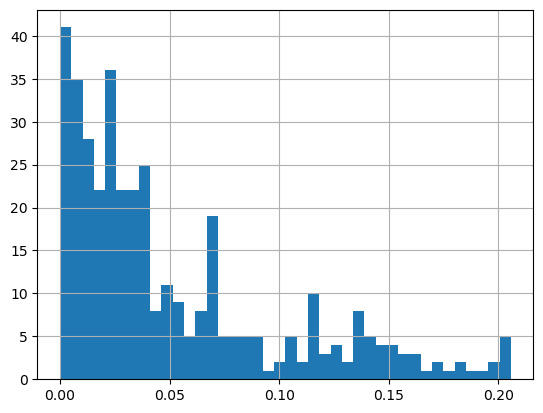

In [17]:
df_ks_res["statistic"].hist(bins=40)

In [82]:
# t5.sort_values('statistic', ascending=False).head(30)

In [58]:
def compare_distr(key, col):
    df_joined, cols = prepare_dfs(d_df[key], d_df["base"])
    t4 = df_joined[col, "target"].toPandas()
    t4_0 = t4[t4["target"] == 0]
    t4_1 = t4[t4["target"] == 1]
    ax = t4_0[t4_0[col] < 1000000][col].hist(bins=40, log=True, alpha=0.4)
    t4_1[t4_1[col] < 1000000][col].hist(bins=40, ax=ax, log=True)

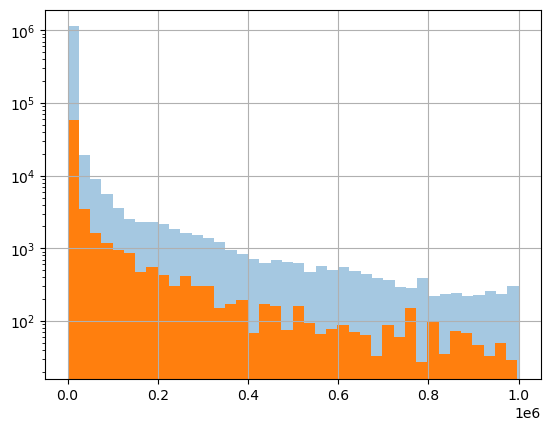

In [59]:
compare_distr("credit_bureau_b_2", "pmts_dpdvalue_108P")

In [62]:
df_ks_res[df_ks_res["key"] == "static_0"].sort_values(
    "statistic", ascending=False
).head(10)

,Unnamed: 0,key,col,statistic,pvalue,statistic_location,statistic_sign
184,184,static_0,avgdpdtolclosure24_3658938P,0.198075,0.0,0.00000,1
236,236,static_0,lastrejectreason_759M,0.190734,0.0,0.00000,1
237,237,static_0,lastrejectreasonclient_4145040M,0.186925,0.0,0.00000,1
299,299,static_0,pctinstlsallpaidlate1d_3546856L,0.182566,0.0,0.19868,1
297,297,static_0,pctinstlsallpaidearl3d_427L,0.180334,0.0,0.51042,-1
300,300,static_0,pctinstlsallpaidlate4d_3546849L,0.173328,0.0,0.12371,1
235,235,static_0,lastrejectcredamount_222A,0.171592,0.0,400000.00000,-1
301,301,static_0,pctinstlsallpaidlate6d_3546844L,0.163693,0.0,0.10983,1
229,229,static_0,lastcancelreason_561M,0.160961,0.0,0.00000,1
272,272,static_0,numinstlswithdpd10_728L,0.158829,0.0,0.00000,1


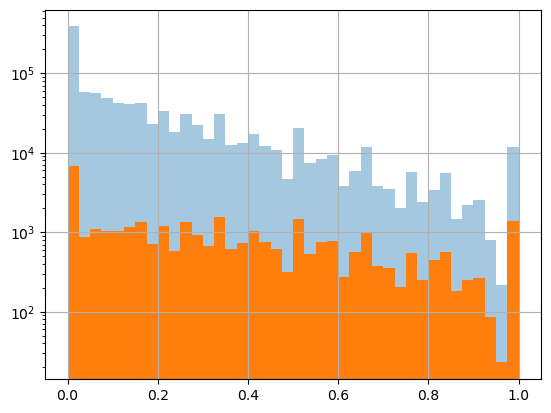

In [65]:
compare_distr("static_0", "pctinstlsallpaidlate1d_3546856L")

In [66]:
df_feature_definitions[
    df_feature_definitions["Variable"] == "pctinstlsallpaidlate1d_3546856L"
]["Description"].values

array(['Percentage of installments that are paid 1 or more days after the due date.'],
      dtype=object)

In [78]:
t4.dropna(subset="pmts_dpdvalue_108P").sort_values("pmts_dpdvalue_108P")

,pmts_dpdvalue_108P,pmts_pmtsoverdue_635A,target
0,0.0,0.00000,0
838382,0.0,0.00000,0
838381,0.0,0.00000,0
838380,0.0,0.00000,0
838379,0.0,0.00000,0
...,...,...,...
549642,185124192.0,435.00000,0
549632,185124192.0,407.80002,0
549637,185124192.0,427.00000,0
549605,185124192.0,413.20000,0


<Axes: >

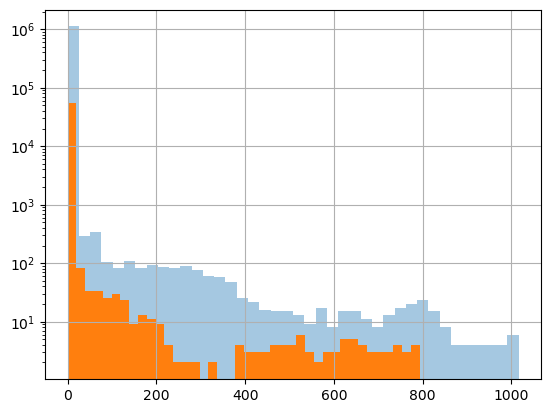

In [81]:
ax = t4_0[t4_0["pmts_dpdvalue_108P"] < 10000]["pmts_pmtsoverdue_635A"].hist(
    bins=40, log=True, alpha=0.4
)
t4_1[t4_1["pmts_dpdvalue_108P"] < 10000]["pmts_pmtsoverdue_635A"].hist(
    bins=40, ax=ax, log=True
)

In [19]:
t3 = d_df["credit_bureau_b_2"]["case_id", "pmts_dpdvalue_108P", "pmts_pmtsoverdue_635A"]
# t3.show(10)

+-------+------------------+---------------------+
|case_id|pmts_dpdvalue_108P|pmts_pmtsoverdue_635A|
+-------+------------------+---------------------+
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
|    467|               0.0|                  0.0|
+-------+------------------+---------------------+
only showing top 10 rows



In [30]:
funs = [min, mean, median, max, std]
aggregate = ["pmts_dpdvalue_108P", "pmts_pmtsoverdue_635A"]


exprs = [f(col(c)) for f in funs for c in aggregate]

t4 = t3.groupby("case_id").agg(*exprs)

In [39]:
dfp_lgb = t4.join(d_df["base"]["case_id", "target"], "case_id", "right")

In [44]:
dfp_lgb.select(
    *(count(when(col(c).isNull(), c)).alias(c) for c in dfp_lgb.columns)
).show()

+-------+-----------------------+--------------------------+-----------------------+--------------------------+--------------------------+-----------------------------+-----------------------+--------------------------+-----------------------+--------------------------+------+
|case_id|min(pmts_dpdvalue_108P)|min(pmts_pmtsoverdue_635A)|avg(pmts_dpdvalue_108P)|avg(pmts_pmtsoverdue_635A)|median(pmts_dpdvalue_108P)|median(pmts_pmtsoverdue_635A)|max(pmts_dpdvalue_108P)|max(pmts_pmtsoverdue_635A)|std(pmts_dpdvalue_108P)|std(pmts_pmtsoverdue_635A)|target|
+-------+-----------------------+--------------------------+-----------------------+--------------------------+--------------------------+-----------------------------+-----------------------+--------------------------+-----------------------+--------------------------+------+
|      0|                1490244|                   1490244|                1490244|                   1490244|                   1490244|                      149024

In [45]:
dfp_lgb.count()

1526659

In [41]:
dfp_lgb.limit(10).toPandas()

,case_id,min(pmts_dpdvalue_108P),min(pmts_pmtsoverdue_635A),avg(pmts_dpdvalue_108P),avg(pmts_pmtsoverdue_635A),median(pmts_dpdvalue_108P),median(pmts_pmtsoverdue_635A),max(pmts_dpdvalue_108P),max(pmts_pmtsoverdue_635A),std(pmts_dpdvalue_108P),std(pmts_pmtsoverdue_635A),target
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [72]:
df_ks_res[df_ks_res["key"] == "credit_bureau_a_1"].sort_values(
    "statistic", ascending=False
).head(10)

,key,col,statistic,pvalue,statistic_location,statistic_sign
361,credit_bureau_a_1,overdueamountmax_35A,0.091823,0.0,478.58798,1
359,credit_bureau_a_1,overdueamountmax2_398A,0.091374,0.0,632.59000,1
351,credit_bureau_a_1,numberofoverdueinstlmax_1151L,0.091176,0.0,5.00000,1
330,credit_bureau_a_1,dpdmax_757P,0.090952,0.0,4.00000,1
334,credit_bureau_a_1,dpdmaxdateyear_896T,0.076606,0.0,2017.00000,1
366,credit_bureau_a_1,periodicityofpmts_1102L,0.071526,0.0,360.00000,1
365,credit_bureau_a_1,overdueamountmaxdateyear_994T,0.068593,0.0,2017.00000,1
356,credit_bureau_a_1,overdueamount_31A,0.040531,0.0,2950.00000,1
353,credit_bureau_a_1,numberofoverdueinstls_834L,0.040492,0.0,1.00000,1
322,credit_bureau_a_1,contractst_964M,0.040307,0.0,0.00000,-1


# Features

In [ ]:
d_df.keys()

In [ ]:
df_base = d_df["base"].toPandas()

## Basic min/max

In [ ]:
# f = 'tax_registry_c_1'
# t5 = d_df[f].limit(100000).toPandas()
# date_cols = []
# for col in t5.columns:
#     try:
#         if t5[~t5[col].isna()][col].shape[0] > 0:
#             pd.to_datetime(t5[col], format='%Y-%m-%d')
#             date_cols.append(col)
#     except Exception as e:
#         pass

In [ ]:
date_cols

In [ ]:
d_df[f].printSchema()

In [ ]:
d_df["applprev_1"].groupby("case_id").count().sort("count", ascending=False).show(50)

In [ ]:
d_df["applprev_1"][d_df["applprev_1"]["case_id"] == 1331766].toPandas().sort_values(
    "creationdate_885D"
)

## debitcard_1

In [ ]:
t5 = d_df["debitcard_1"].join(d_df["base"], "case_id", "left").toPandas()

t5["openingdate_857D"] = pd.to_datetime(t5["openingdate_857D"])
t5["date_decision"] = pd.to_datetime(t5["date_decision"])
t5["target"] = t5["target"].astype(int)

In [ ]:
t5["days_since_open_until_decision"] = (
    t5["date_decision"] - t5["openingdate_857D"]
).dt.days

In [ ]:
t5

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

t5_s = t5.drop(columns=["openingdate_857D", "date_decision"])

t5_train, t5_test = train_test_split(t5_s, test_size=0.2)

In [ ]:
train_data = lgb.Dataset(t5_train.drop(columns="target"), label=t5_train["target"])
test_data = lgb.Dataset(t5_test.drop(columns="target"), label=t5_test["target"])
param = {"num_leaves": 31, "objective": "binary", "metric": "mae"}

In [ ]:
def focal_loss_lgb(y_pred, dtrain, alpha, gamma):
    a, g = alpha, gamma
    y_true = dtrain.label

    def fl(x, t):
        p = 1 / (1 + np.exp(-x))
        return (
            -(a * t + (1 - a) * (1 - t))
            * ((1 - (t * p + (1 - t) * (1 - p))) ** g)
            * (t * np.log(p) + (1 - t) * np.log(1 - p))
        )

    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess


def focal_loss_lgb_eval_error(y_pred, dtrain, alpha, gamma):
    a, g = alpha, gamma
    y_true = dtrain.label
    p = 1 / (1 + np.exp(-y_pred))
    loss = (
        -(a * y_true + (1 - a) * (1 - y_true))
        * ((1 - (y_true * p + (1 - y_true) * (1 - p))) ** g)
        * (y_true * np.log(p) + (1 - y_true) * np.log(1 - p))
    )
    # (eval_name, eval_result, is_higher_better)
    return "focal_loss", np.mean(loss), False

In [ ]:
num_round = 10

focal_loss = lambda x, y: focal_loss_lgb(x, y, alpha=0.25, gamma=1.0)
focal_loss_eval = lambda x, y: focal_loss_lgb_eval_error(x, y, alpha=0.25, gamma=1.0)

bst = lgb.train(
    param,
    train_data,
    num_round,
    #                 fobj=focal_loss,
    feval=focal_loss_eval,
    valid_sets=[test_data],
)

In [ ]:
bst.best_score

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [ ]:
t5 = t5.na.fill(-1)

In [ ]:
t6 = t5.toPandas()

In [ ]:
t6["target"].value_counts()

In [ ]:
vectorAssembler = VectorAssembler(
    inputCols=["last180dayaveragebalance_704A"], outputCol="features"
)
v_t5 = vectorAssembler.transform(t5.limit(50))
v_t5 = v_t5.select(["features", "target"])
v_t5.show(3)

In [ ]:
splits = v_t5.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [ ]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(
    featuresCol="features",
    labelCol="target",
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

In [ ]:
lr_model.summary.rootMeanSquaredError

In [ ]:
lr_model.predict(test_df)

In [ ]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="target",
    regParam=0.0,
    solver="normal",
    weightCol="weight",
)

In [ ]:
t5

In [ ]:
df_debitcard_1 = d_df["debitcard_1"].orderBy(["case_id", "num_group1"]).toPandas()

In [ ]:
t5 = pd.merge(df_debitcard_1, df_base, "left", "case_id")

In [ ]:
t5

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)
reg.coef_
reg.intercept_
reg.predict(np.array([[3, 5]]))

In [ ]:
df_debitcard_1[df_debitcard_1["last180dayaveragebalance_704A"].isna()].shape[
    0
] / df_debitcard_1.shape[0]

In [ ]:
df_debitcard_1["last180dayaveragebalance_704A"].hist(bins=40, log=True)

In [ ]:
df_debitcard_1[~df_debitcard_1["last180dayaveragebalance_704A"].isna()]

In [ ]:
df_debitcard_1[~df_debitcard_1["last180dayturnover_1134A"].isna()]

In [ ]:
df_base = d_df["base"].toPandas()

In [ ]:
t5 = pd.merge(df_debitcard_1, df_base, "left", "case_id")

In [ ]:
col = "last180dayaveragebalance_704A"
_max = 10000
ax = t5[(t5["target"] == 1) & (t5[col] < _max)][col].hist(bins=40, log=True, alpha=0.5)
t5[(t5["target"] == 0) & (t5[col] < _max)][col].hist(
    bins=40, ax=ax, log=True, alpha=0.5
)

In [ ]:
df_base["target"].value_counts()

In [ ]:
t4 = df_base.groupby("MONTH")["target"].value_counts().reset_index()
t4

In [ ]:
t5 = pd.pivot_table(t4, "count", "MONTH", "target")
t5.columns = [str(x) for x in t5.columns]

In [ ]:
t5["pct"] = (t5["1"] / (t5["0"] + t5["1"])) * 100

In [ ]:
t5

In [ ]:
d_df.keys()

In [ ]:
df_feature_definitions[
    df_feature_definitions["Variable"] == "last180dayaveragebalance_704A"
]["Description"].values[0]